In [ ]:
학습목표 : ARIMA 모형을 적용하여 환률 데이터 예측해보기
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/sm-joo/sm-joo/master/DEXKOUS.csv', parse_dates=['DATE'], index_col='DATE')

In [3]:
df.columns=['KOUS']
df['KOUS'].replace('.', '', inplace=True)
df['KOUS']=pd.to_numeric(df['KOUS'])
df['KOUS'].fillna(method='ffill', inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1306 entries, 2015-03-13 to 2020-03-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KOUS    1306 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB


In [5]:
#최근 데이터를 분리하기 (2019)
df= df[(df.index> '2019-01-01')&(df.index<'2020-01-01')]


In [6]:
# 첫번째로 ARIMA(q,k,q) --> K값 결정하기 
adfuller(df.KOUS)

(-1.8342899250680114,
 0.36357542996557135,
 2,
 257,
 {'1%': -3.4560535712549925,
  '5%': -2.8728527662442334,
  '10%': -2.5727985212493754},
 1453.3457437081727)

In [8]:
#P-value가 0.05보다 높기 때문에 한번 차분해준다.
adfuller(df.KOUS.diff().dropna())

#P-Value값이 0에 가까운값이 나왔으므로 K= 1로 결정(1차 차분이 안정적이다.)

(-10.572632524492828,
 7.239046680336767e-19,
 1,
 257,
 {'1%': -3.4560535712549925,
  '5%': -2.8728527662442334,
  '10%': -2.5727985212493754},
 1446.168602565303)

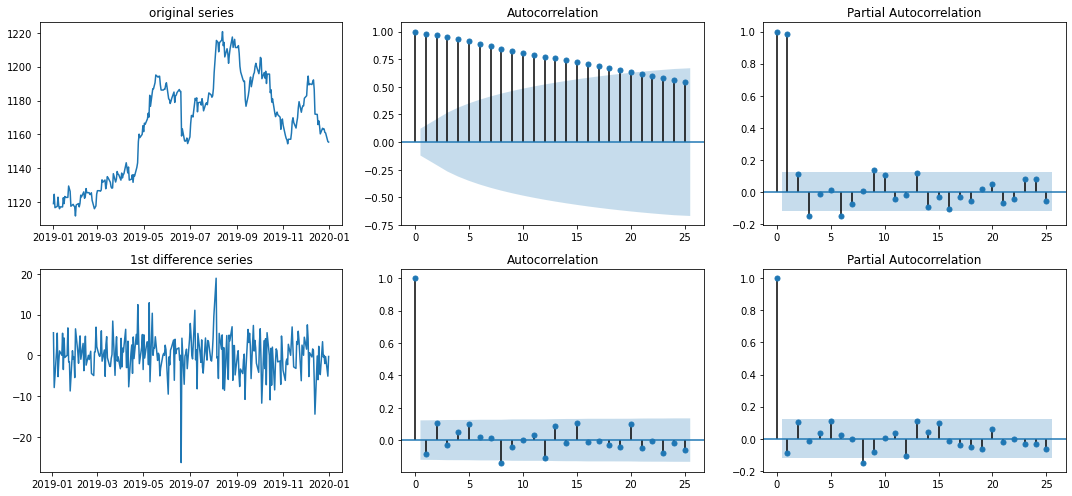

In [9]:
# ARIMA(p,k,q) --> p,q 결정
# 2 x 3 subplots으로 시각화 해서, 나머지 값을 결정하기
figure, axes= plt.subplots(2, 3, figsize=(15,7))
axes[0,0].plot(df.KOUS)
axes[0,0].set_title('original series')
axes[1,0].plot(df.KOUS.diff())
axes[1,0].set_title('1st difference series')
plot_acf(df.KOUS,axes[0,1])
plot_pacf(df.KOUS,axes[0,2])
plot_acf(df.KOUS.diff().dropna(),axes[1,1])
plot_pacf(df.KOUS.diff().dropna(),axes[1,2])
plt.tight_layout()
plt.show()


In [ ]:
 #AR차수 : 3차 or 1차
# MA 차수 : 2차 Or 0차


In [12]:
# ARIMA 예측 모델링
# ARIMA의 차수는 (3,1,2) -> (2,1,2) freq= B 는 평일만 주가옵션이 변동하기 때문 
model  = ARIMA ( df.KOUS, order = (2,1,2), freq = 'B')
model_fit = model.fit(trend = 'nc')
print(model_fit.summary())
# q 값을 3으로 두었을때,p-value가 0.05보다 컸기 때문에 2차분으로 변경해서해야한다. ggjmcjkfvk

C:\Users\hongm\anaconda3\envs\ck\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -769.208
Method:                       css-mle   S.D. of innovations              4.715
Date:                Sun, 27 Dec 2020   AIC                           1548.416
Time:                        19:08:36   BIC                           1566.200
Sample:                    01-03-2019   HQIC                          1555.566
                         - 12-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -1.2447      0.243     -5.123      0.000      -1.721      -0.768
ar.L2.D.KOUS    -0.7340      0.257     -2.851      0.004      -1.239      -0.229
ma.L1.D.KOUS     1.1778      0.245      4.80

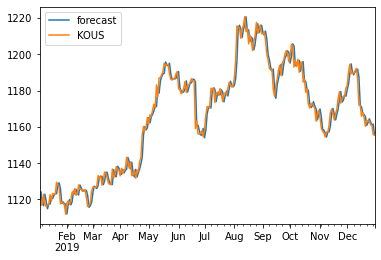

In [13]:
#예측값을 그래프로 나타내기
model_fit.plot_predict()
plt.show()
#이는 과거 데이터의 예측값이므로 아무 의미없는 데이터이다. 

In [14]:
#Training set, Test set을 나누어서 학습과 평가하기
#시계열 예측의 경우는 짧은 기간의 데이터를 학습시켜, 잛은 기간의 데이터 예측을 하는편이 더욱 좋은 값을 얻을 수 있다. 
#train 날짜 : 30일 test(알고자 하는 예측 값) : 5일
train = df.iloc[0:30]
test= df.iloc[30:35]
test.shape

(5, 1)

In [19]:
model = ARIMA(train, order=(2,1,2), freq='B')
model_fit= model.fit(trend='nc')
fc, se, conf = model_fit.forecast(5, alpha= 0.05)

In [20]:
fc_series = pd.Series(fc, index =test.index)
lower_series = pd.Series(conf[:,0], index = test.index)
upper_series = pd.Series(conf[:,1], index = test.index)

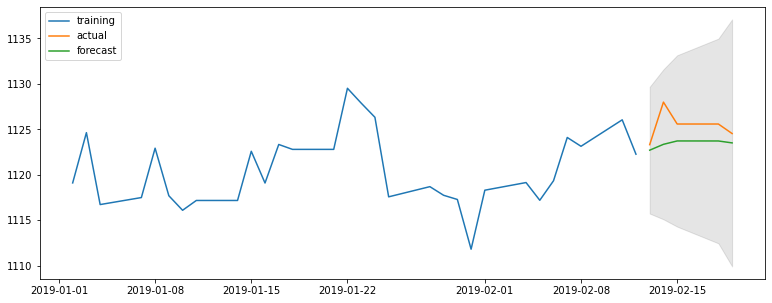

In [21]:
#plot 
plt.figure(figsize = (13,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label = 'forecast')
plt.fill_between(test.index, lower_series, upper_series, color='black', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

In [ ]:
#결과적으로 예측값과 실제값의 오차 많이 나는 것을 알 수 있다. 이는 분석 모델인 ARIMA의 
#특성상 외부요인으로 인한 분석값을 예상하지 못했기 때문이다. 
#하지만 lower_series, upper_series 안에서의 기대값은 안에 포함되어 있는것을 확인할수 있었다. 
